In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")



In [2]:
# Load and inspect data

intakes = pd.read_csv("Austin_Animal_Center_Intakes.csv", low_memory=False)
outcomes = pd.read_csv("Austin_Animal_Center_Outcomes.csv", low_memory=False)
stray = pd.read_csv("Austin_Animal_Center_Stray_Map.csv", low_memory=False)

In [19]:
# Show basic info
print("Intakes Info")
print(intakes.info())
print(intakes.head())

print("Outcomes Info")
print(outcomes.info())
print(outcomes.head())

print("Stray Info")
print(stray.info())
print(stray.head())


Intakes Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155815 entries, 0 to 155814
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   animal_id         155815 non-null  object        
 1   name              110885 non-null  object        
 2   datetime          155815 non-null  datetime64[ns]
 3   monthyear         155815 non-null  object        
 4   found_location    155815 non-null  object        
 5   intake_type       155815 non-null  object        
 6   intake_condition  155815 non-null  object        
 7   animal_type       155815 non-null  object        
 8   sex_upon_intake   155813 non-null  object        
 9   age_upon_intake   155814 non-null  object        
 10  breed             155815 non-null  object        
 11  color             155815 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 14.3+ MB
None
  animal_id      name            datetim

In [14]:
# Clean and prepare datasets
def clean_cols(df):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("/", "_")
        .str.replace(".", "")
    )
    return df

intakes = clean_cols(intakes)
outcomes = clean_cols(outcomes)

# Convert date columns
for df in [intakes, outcomes]:
    for col in df.columns:
        if "date" in col or "datetime" in col:
            df[col] = pd.to_datetime(df[col], errors="coerce")

# Merge datasets
merged = pd.merge(intakes, outcomes, on="animal_id", suffixes=("_intake", "_outcome"), how="inner")

# Create new feature: length of stay (days)
merged["length_of_stay_days"] = (merged["datetime_outcome"] - merged["datetime_intake"]).dt.total_seconds() / (24*3600)

# Create live outcome column
live_outcomes = ["Adoption","Return to Owner","Transfer","Foster","Rescue","Relocate","Reclaimed"]
merged["live_outcome"] = merged["outcome_type"].isin(live_outcomes).astype(int)

# Check missing values
print("Missing Values")
print(merged.isnull().sum().sort_values(ascending=False).head(15))

Missing Values
outcome_subtype       120762
name_outcome           45647
name_intake            45647
outcome_type              44
age_upon_outcome           3
sex_upon_intake            2
sex_upon_outcome           2
age_upon_intake            1
animal_id                  0
animal_type_intake         0
intake_condition           0
intake_type                0
found_location             0
datetime_intake            0
monthyear_intake           0
dtype: int64


In [15]:
# Explore and find insights
# Key Performance Indicators
live_rate = merged["live_outcome"].mean() * 100
median_los = merged["length_of_stay_days"].median()

print("Shelter Performance KPIs")
print(f"Live Outcome Rate: {live_rate:.2f}%")
print(f"Median Length of Stay: {median_los:.2f} days")


Shelter Performance KPIs
Live Outcome Rate: 92.63%
Median Length of Stay: 5.33 days


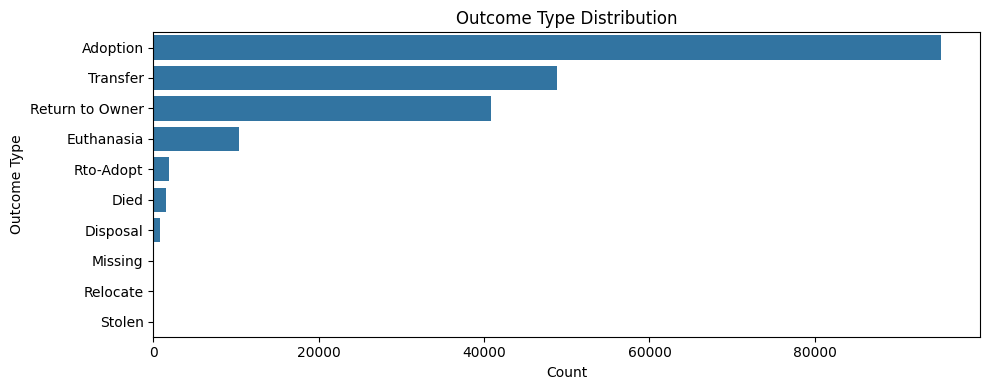

In [6]:
# Outcome distribution
plt.figure(figsize=(10,4))
sns.countplot(y="outcome_type", data=merged, order=merged["outcome_type"].value_counts().index)
plt.title("Outcome Type Distribution")
plt.xlabel("Count")
plt.ylabel("Outcome Type")
plt.tight_layout()
plt.show()

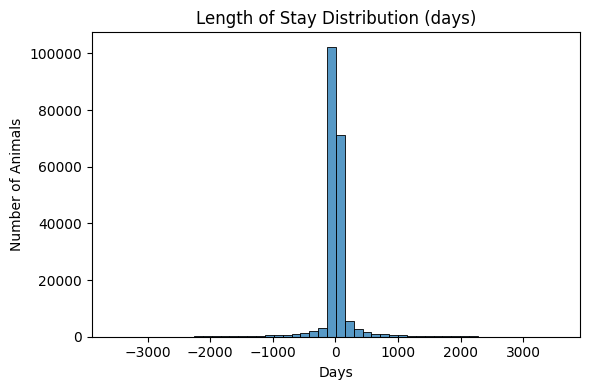

In [7]:
# Length of stay histogram
plt.figure(figsize=(6,4))
sns.histplot(merged["length_of_stay_days"].dropna(), bins=50)
plt.title("Length of Stay Distribution (days)")
plt.xlabel("Days")
plt.ylabel("Number of Animals")
plt.tight_layout()
plt.show()

In [16]:
# Live outcome rate by species
species_live = merged.groupby("animal_type_outcome")["live_outcome"].mean().sort_values(ascending=False)
print("Live Outcome Rate by Species")
print(species_live * 100)

Live Outcome Rate by Species
animal_type_outcome
Dog          96.300824
Cat          94.430927
Livestock    88.461538
Bird         73.868047
Other        24.721954
Name: live_outcome, dtype: float64


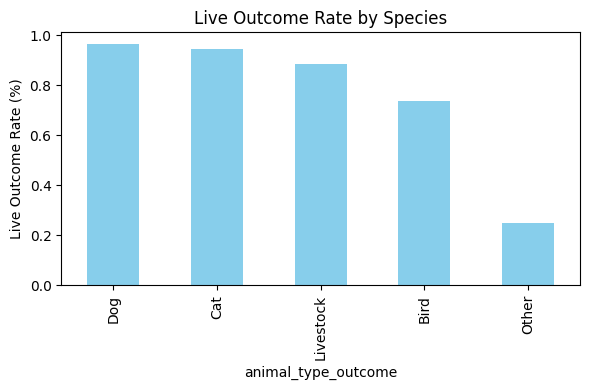

In [9]:
plt.figure(figsize=(6,4))
species_live.plot(kind="bar", color="skyblue")
plt.title("Live Outcome Rate by Species")
plt.ylabel("Live Outcome Rate (%)")
plt.tight_layout()
plt.show()


In [17]:
# Median length of stay by outcome type
los_by_outcome = merged.groupby("outcome_type")["length_of_stay_days"].median().sort_values()
print("Median Length of Stay by Outcome Type (days)")
print(los_by_outcome)

Median Length of Stay by Outcome Type (days)
outcome_type
Euthanasia           0.538889
Disposal             0.804861
Relocate             0.990625
Return to Owner      1.242361
Died                 3.846181
Transfer             4.113194
Rto-Adopt            8.106944
Adoption            11.985417
Missing             28.139236
Stolen             192.653472
Name: length_of_stay_days, dtype: float64


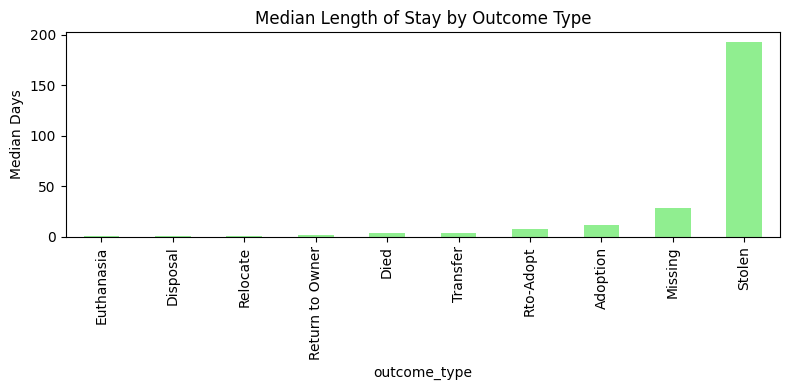

In [12]:
plt.figure(figsize=(8,4))
los_by_outcome.plot(kind="bar", color="lightgreen")
plt.title("Median Length of Stay by Outcome Type")
plt.ylabel("Median Days")
plt.tight_layout()
plt.show()

In [18]:
# Business Summary

print("Business Insights Summary")
print("""
1. The Austin Animal Shelter’s overall live outcome rate indicates how well they are achieving
   their mission of reaching at least a 95% live outcome rate for all animals.
2. The median length of stay helps identify how efficiently animals are being placed.
3. Species differences show which animals might need more support programs:
   - If cats have lower live outcome rates than dogs, targeted foster or adoption events can help.
4. Longer median stays for certain outcome types may suggest bottlenecks in the process.
5. Next steps:
   - Focus community outreach on the species or intake types with lower live outcomes.
   - Encourage faster adoption through better promotion and foster engagement.
""")


Business Insights Summary

1. The Austin Animal Shelter’s overall live outcome rate indicates how well they are achieving
   their mission of reaching at least a 95% live outcome rate for all animals.
2. The median length of stay helps identify how efficiently animals are being placed.
3. Species differences show which animals might need more support programs:
   - If cats have lower live outcome rates than dogs, targeted foster or adoption events can help.
4. Longer median stays for certain outcome types may suggest bottlenecks in the process.
5. Next steps:
   - Focus community outreach on the species or intake types with lower live outcomes.
   - Encourage faster adoption through better promotion and foster engagement.

